# Few-Shot Learning for Rooftop Segmentation in Satellite Imagery

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-tutorial-group-1/blob/main/notebooks/tutorial_few_shot_learning.ipynb)


This tutorial introduces few-shot learning techniques for semantic segmentation in satellite imagery using high-resolution images from Geneva, Switzerland. We will demonstrate how Prototypical Networks can learn meaningful rooftop representations from only a few labeled examples and generalize to new geographic areas with minimal annotation effort.

### Learning Outcomes

By the end of the tutorial, you will be able to:

- Understand the core concepts behind **Few-Shot Learning** and **Few-Shot Semantic Segmentation**
- Work with **satellite imagery**, geographic splits, and pixel-level segmentation masks
- Implement **Prototypical Networks** with episodic training for segmentation tasks
- Evaluate model performance using metrics such as **IoU** and interpret FSL model behavior
- Reflect on **policy-relevant applications** such as rooftop solar assessment and data-scarce mapping tasks


### Prerequisites  

- Intermediate Python programming  
- Familiarity with PyTorch  
- Basics of Machine and Deep Learning  
- Understanding of convolutional neural networks  

Apart from that, you'll need a strong interest and some motivation to learn a new method 😉


## Table of Contents

* [Memo](#memo)
* [Overview](#overview)
* [Background & Introduction](#background-and-prereqs)
* [Theoretical Foundation](#theoretical-foundation)
* [Data Description](#data-description)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion & Limitations](#discussion-limitations)
* [⭐ Challenge ⭐](#challenge)
* [Further Ressources](#further-ressources)
* [References](#references)

---

<a name="memo"></a>
## Memo

This notebook offers an in-depth look at few-shot learning (FSL), an advanced deep learning technique that enables models to generalize effectively from only a small number of training examples. FSL becomes particularly valuable when traditional supervised learning is impractical. For instance, when annotation is expensive, requires specialized expertise, or when data is scarce.  

Few-shot learning is especially relevant in the context of public policy, where we often face limited access to comprehensive, well-curated datasets or lack the resources to collect large amounts of training data. Applications span a wide range of policy areas, including disaster classification (Lee et al., 2025), urban planning (Hu et al., 2022) and health policy, where FSL has supported COVID-19 detection (Jadon, 2021) and the diagnosis of rare genetic diseases (Alsentzer et al., 2025).  

Beyond classification tasks, FSL also performs well in <b>segmentation problems</b>, helping identify different types of buildings, vegetation such as forest cover (Puthumanaillam & Verma, 2023) and performing well in remote sensing imagery segmentation (Chen et al., 2022). All of these examples share a common challenge: <b>limited data</b>. 

Few-shot learning helps address this constraint, and we encounter similar situations within our own institution. A clear illustration is our Wildlife Trade Monitoring Project (WTMP), where labeled examples of rare, endangered species are extremely scarce and often inconsistent. This emphasizes just how valuable few-shot learning approaches can be.  
Today, a wide range of few-shot learning frameworks and architectures are available. Some of the most widely used include model-agnostic meta-learning (Finn, Abbeel & Levine, 2017), prototypical networks (Snell, Swersky & Zemel, 2017), and relation networks (Sung et al., 2018). Over the past few years, the field has continued to evolve, giving rise to more specialized and state-of-the-art techniques, such as SegPPD-FS for semantic segmentation (Ge et al., 2025) and CDCNet for classification tasks (Li et al., 2025).   

Because of its importance to public policy and its potential value for our organization, this notebook takes a deep dive into prototypical networks semantic segmentation of building rooftops. This is an essential step for many downstream tasks, such as assessing rooftop suitability for solar panel installation. By walking through this method, the notebook aims to help our team to better understand and apply this powerful technique in our day-to-day work.

<a name="overview"></a>
## Overview and Introduction

Dear colleagues,

In this notebook, we will introduce the concept of few-shot learning (FSL). As briefly mentioned earlier, FSL is an advanced deep learning paradigm that enables models to generalize from only a handful of annotated samples. In particular, we will focus on <b>prototypical networks</b>, which learn a metric space where each class is represented by a prototype (usually the mean embedding of its support examples) and then classify query samples based on their distance to these prototypes (more details will be provided below). 

This method can be applied to semantic segmentation tasks, allowing us to partition an image into meaningful regions.

To guide you through this approach, we will work with the Geneva Satellite Images dataset. This dataset contains high-resolution (250×250 PNG tiles) satellite imagery of Geneva, Switzerland, along with pixel-level segmentation masks that delineate building rooftops. It was developed by EPFL’s Solar Energy and Building Physics Laboratory and is publicly available on [HuggingFace](https://huggingface.co/datasets/raphaelattias/overfitteam-geneva-satellite-images)
 (Castello et al., 2021).  

The goal of this notebook is to demonstrate how few-shot learning can be used for rooftop semantic segmentation, with applications such as assessing the suitability of buildings for solar panels.  

Throughout the notebook, we will walk you through how to:  

- Load and preprocess satellite imagery
- Build a few-shot segmentation model
- Train the model using prototypical networks
- Evaluate segmentation performance  
  
Please follow the code and try to understand how to apply few-shot learning to segment rooftops in new satellite images. You can run each cell in sequence. At every step, we provide clear explanations of what is happening. A pre-recorded video is also available if you prefer a more visual learning format.  

If you have any questions about few-shot learning or need help with its implementation, please feel free to reach out. Our contact information is provided in the [README.md](https://github.com/hertie-data-science-lab/tutorial-new-tutorial-group-1/blob/main/README.md).  
 
Happy learning!  

Your **Public Innovation Lab (PILAB)**  

---

<a name="theoretical-foundation"></a>
## Theorotical Foundation

### Key Concepts

- **Few-Shot Learning:** Few-shot learning aims to train models that can recognize new classes from only a handful of labeled examples by leveraging prior knowledge learned from many related tasks.

<div style="text-align: center;">
  <iframe
    width="560" height="315"
    src="https://www.youtube.com/embed/hE7eGew4eeg"
    title="YouTube video player"
    frameborder="0"
    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture"
    allowfullscreen>
  </iframe>
</div>


- **Semantic Segmentation:** In the context of semantic segmentation, this means learning to assign a class label to every pixel in an image, even when only a few annotated images are available for each class.

- **Prototypical Networks:** Prototypical Networks tackle this by mapping pixels (or patches) into an embedding space where each class is represented by a prototype, typically the mean embedding of its support examples. At inference time, each pixel in a query image is classified by measuring its distance to these class prototypes, enabling accurate pixel-wise segmentation in new scenes with very limited labeled data.

![](presentation/figures/illustration_prototypical_network.png)

*Figure 1: Overview of the Self-Regularized Prototypical Network Architecture. Adapted from [Ding et al. (2022)](https://arxiv.org/pdf/2210.16829).*


### Software Requirements

Now lets get started by installing the required packages. 

> **Note**: If you are using Google Colab, these packages are already installed. If you are running this notebook locally, please uncomment and run the following cell to install the necessary libraries. Make sure to have a fresh environment set up.

In [ ]:
# uncomment the following line to install required packages
# !pip install -q huggingface_hub torch torchvision matplotlib torchgeo

In [ ]:
import sys
import os

# Add parent directory to sys.path to allow imports from there
sys.path.append(os.path.abspath(".."))

import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from huggingface_hub import snapshot_download

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


/Users/elena/miniconda3/envs/.venv-dl-ps1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


<a name="data-description"></a>
## Data Description

The dataset you will use consists of **1,050** high-resolution satellite imagery of Geneva's building rooftops with corresponding binary segmentation masks for rooftop detection.

**Dataset Properties:**
- Image Type: RGB satellite imagery
- Labels: Binary masks (0 = background, 1 = rooftop)
- Resolution: Variable, resized to 256x256 for training

## Data Download

The dataset is stored on the Hugging Face Hub and each tile comes with:

- a **RGB satellite image**, and
- a **binary mask** indicating pixels that belong to rooftops suitable for PV installations.

Using 🤗 `huggingface_hub.snapshot_download` 🤗 we download the dataset to the local filesystem. 

> **Note**: To make the data download process more smoothly please put your Hugging Face Token in an `.env` file at the root of the directory or set it as an (environment) variable.

You can either do it by running the following in your terminal:

```bash
export HF_TOKEN='your_token_here'
```

Or by creating a `.env` file with the following content: 

```
HF_TOKEN='your_token_here'
```

Or by simply setting the token directly in the code cell below (not recommended for security reasons):

```python
HF_TOKEN = 'your_token_here'
```

In [4]:
## Download dataset once (cached afterward)

def download_geneva_dataset():
    token = os.getenv("HF_TOKEN")  # set your HF_TOKEN env variable if you have one, else None

    dataset_root = snapshot_download(
        repo_id="raphaelattias/overfitteam-geneva-satellite-images",
        repo_type="dataset",
        token=token,
        resume_download=True
    )

    print(f"Dataset downloaded to: {dataset_root}")
    return dataset_root

dataset_root = download_geneva_dataset()

/Users/elena/miniconda3/envs/.venv-dl-ps1/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 2111 files: 100%|██████████| 2111/2111 [00:00<00:00, 49206.54it/s]

Dataset downloaded to: /Users/elena/.cache/huggingface/hub/datasets--raphaelattias--overfitteam-geneva-satellite-images/snapshots/3f90d759384e4cd38276290521b6f6b03ddfcf87


## Data Preprocessing

To work with PyTorch, you will define a `Dataset` class that returns `(image, mask)` pairs.

### Data Transformation  

- In a first step, you resize the images to a fixed resolution of **256 × 256**, convert them to PyTorch tensors, and normalise with **ImageNet mean and standard deviation**. This is compatible with the pretrained ResNet18 backbone we will use later. 
- Then, you resize the masks using **nearest-neighbour interpolation** to avoid mixing labels at boundaries, converted to tensors in `[0, 1]`, and then **binarised** pixels so that any non-zero value is treated as rooftop (class 1): mask pixels can be either background or rooftop.

The `GenevaRooftopDataset` class wraps these steps and reads from a structured folder layout with `images/` and `labels/` subdirectories. 

### Train-Test: Geographical Split  

Subsequently, you can define the trainig set to be images from the northern (`1310_11`) and southern (`1310_31`) parts of Geneva. You extract the grid ID from the image file. As test set, you can use images from the central (`1310_13`) part of the city. We expect periphery of the city to have higher variety of rooftop types from the city center, and the areas of the city to be structurally different to a certain degree.

<div style="text-align: center;">
  <img src="presentation/figures/geneva-map-gif.gif" alt="figure" style="max-width: 80%;">
</div>


In [ ]:
## Image transformation and dataset class

IMAGE_SIZE = 256  # resize tiles to this

img_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ColorJitter(contrast=0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
        transforms.ToTensor(),  # gives float [0,1] for grayscale
    ]
)


def get_grid_id_from_filename(fname):
    parts = fname.split("_")
    # 3th and 3th parts give the grid ID
    return f"{parts[2]}_{parts[3]}"


class GenevaRooftopDataset(Dataset):
    """
    Dataset filtered by geographic grid IDs.
    Can read from multiple splits (train/val/test) at once.
    """

    def __init__(self, root, splits=["train", "val", "test"], category="all", grid_ids=None):
        super().__init__()
        self.root = root
        self.category = category
        self.grid_ids = grid_ids
        self.files_info = []  # list of tuples (split, filename)

        # Collect files from all specified splits
        for split in splits:
            image_dir = os.path.join(root, split, "images", category)
            label_dir = os.path.join(root, split, "labels", category)

            all_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

            # Filter by grid_ids if provided
            if grid_ids is not None:
                all_files = [f for f in all_files if get_grid_id_from_filename(f) in grid_ids]

            # Store split info for loading
            self.files_info.extend([(split, f) for f in all_files])

    def __len__(self):
        return len(self.files_info)

    def __getitem__(self, idx):
        split, fname = self.files_info[idx]
        img_path = os.path.join(self.root, split, "images", self.category, fname)
        mask_name = fname.replace(".png", "_label.png")
        mask_path = os.path.join(self.root, split, "labels", self.category, mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = img_transform(img)
        mask = mask_transform(mask)
        mask = (mask > 0.5).float()

        return img, mask

In [6]:
## Train-Test split

train_grids = ["1301_11", "1301_31"]
test_grids = ["1301_13"]

# Train dataset reads from all three folders
train_base = GenevaRooftopDataset(dataset_root, splits=["train", "val", "test"], grid_ids=train_grids)

# Test dataset can read from just one folder or multiple if needed
test_base = GenevaRooftopDataset(dataset_root, splits=["train", "val", "test"], grid_ids=test_grids)

print(f"Train samples: {len(train_base)}, Test samples: {len(test_base)}")

Train samples: 423, Test samples: 102


In [7]:
## Show examples

def plot_overlay(image, mask, alpha=0.4):
    """
    Overlay a binary mask on top of an RGB image.

    image: [H,W,3] float in [0,1]
    mask:  [H,W]   {0,1} (will be resized if needed)
    """
    img = image

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = np.squeeze(mask)

    h, w = img.shape[:2]

    # If mask and image have different spatial size, resize mask
    if mask.shape != (h, w):
        mask_pil = Image.fromarray(mask.astype(np.uint8))
        mask_pil = mask_pil.resize((w, h), resample=Image.NEAREST)
        mask = np.array(mask_pil)

    # Normalize mask to {0,1} just in case
    if mask.max() > 1:
        mask = (mask > 0).astype(np.float32)

    # Create RGB mask
    mask_rgb = np.zeros_like(img)
    mask_rgb[..., 0] = mask  # red channel = rooftop

    overlay = (1 - alpha) * img + alpha * mask_rgb
    return overlay


def show_sample(dataset, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    img, mask = dataset[idx]  # img [3,H,W], mask [1,H,W]

    # Undo normalisation for plotting
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # mask: [1, H, W] -> [H, W]
    mask_np = mask.squeeze(0).numpy()

    overlay_np = plot_overlay(img_np, mask_np)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_np)
    plt.title("Image with Overlay")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Mask (rooftop)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

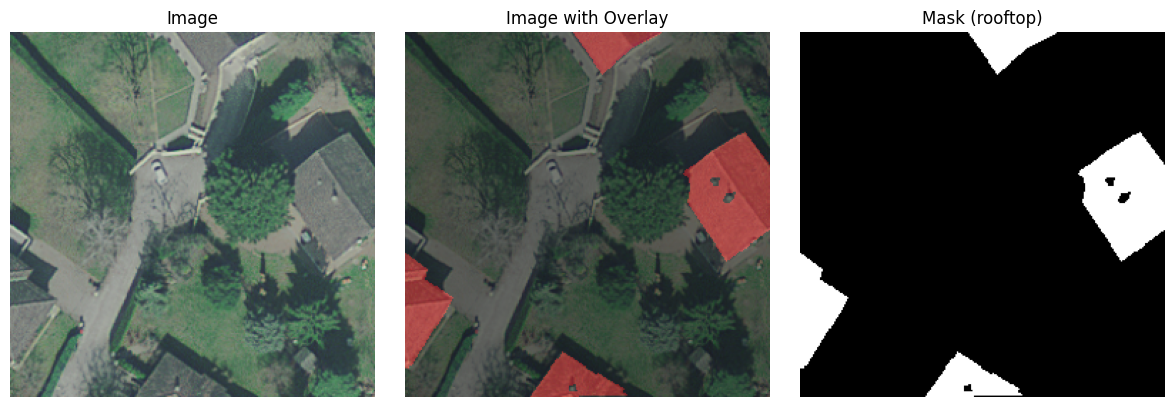

In [8]:
show_sample(train_base)

### Summary: Class Distribution 

You can then compute foreground (rooftop) vs background pixel counts across the train/val/test splits. Rooftops represent ~16–17% of all pixels, while the remaining ~82–83% is background.

Interesting observations:

- Splits maintain similar FG/BG ratios (consistent dataset structure)

- Rooftop pixels are noticeably less frequent (this creates a class imbalance typical for semantic segmentation of small objects)

- Some images contain large rooftop structures, which explains the slightly higher foreground percentage compared to typical urban aerial datasets

In [11]:
def compute_basic_stats_geographic(dataset, name="dataset"):
    """Compute rooftop pixel fraction statistics for a geographic dataset."""
    if len(dataset) == 0:
        raise ValueError(f"Dataset {name} is empty")

    rooftop_fracs = []

    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        rooftop_frac = mask.mean().item()
        rooftop_fracs.append(rooftop_frac)

    rooftop_fracs = np.array(rooftop_fracs)

    print()
    print(f"Rooftop pixel fraction stats for {name} (n={len(dataset)}):")
    print("-" * 20)
    print(f"  mean   : {rooftop_fracs.mean():.3f}")
    print(f"  median : {np.median(rooftop_fracs):.3f}")
    print(f"  min    : {rooftop_fracs.min():.3f}")
    print(f"  max    : {rooftop_fracs.max():.3f}")
    print("-" * 45)

    return {"rooftop_fracs": rooftop_fracs}

In [12]:
train_stats = compute_basic_stats_geographic(train_base, name="train")
test_stats = compute_basic_stats_geographic(test_base, name="test")


Rooftop pixel fraction stats for train (n=423):
--------------------
  mean   : 0.162
  median : 0.131
  min    : 0.001
  max    : 0.972
---------------------------------------------

Rooftop pixel fraction stats for test (n=102):
--------------------
  mean   : 0.170
  median : 0.143
  min    : 0.006
  max    : 0.546
---------------------------------------------


<a name="methodology"></a>
## Methodology  

### Few-shot episodes: support and query

Few-shot learning is typically implemented with **episodic training**. An **episode** is one small training problem that mimics how we will use the model at test time: we see some labelled examples (support) and we must make predictions for new data (query).

In this setting, each episode contains:

- a **support image with its mask** `(img_s, mask_s)`, and  
- a **query image with its mask** `(img_q, mask_q)`.

In the following class, you create an `EpisodeDataset` that wraps the base training dataset. For every episode, it randomly picks two *different* tiles from the training set:

- one becomes the support pair,
- the other becomes the query pair.

During training, the model:

1. looks at the **support image + mask** to learn what rooftops and background look like, and  
2. tries to correctly segment the **query image**, using that information.

The parameter `episodes_per_epoch` defines how many such support–query pairs (episodes) we use in one training epoch. A `DataLoader` iterates over this dataset and gives us **one episode at a time** for training.


In [82]:
class EpisodeDataset(Dataset):
    """
    Yields (support_imgs [K,3,H,W], support_masks [K,1,H,W], query_img, query_mask)
    """

    def __init__(self, base_dataset, episodes_per_epoch=2000, K=1):
        self.base = base_dataset
        self.episodes_per_epoch = episodes_per_epoch
        self.n = len(base_dataset)
        self.K = 1

    def __len__(self):
        return self.episodes_per_epoch

    def __getitem__(self, idx):
        # sample K support + 1 query index
        indices = random.sample(range(self.n), self.K + 1)
        *support_idx, query_idx = indices  # Python unpacking

        # get support items
        support = [self.base[i] for i in support_idx]
        imgs_s, masks_s = zip(*support, strict=False)  # tuples of tensors

        # get query item
        img_q, mask_q = self.base[query_idx]

        # stack support tensors
        imgs_s = torch.stack(imgs_s, dim=0)  # [K, 3, H, W]
        masks_s = torch.stack(masks_s, dim=0)  # [K, 1, H, W]

        return imgs_s, masks_s, img_q, mask_q

In [83]:
episodes_per_epoch = 2000
episode_dataset = EpisodeDataset(train_base, episodes_per_epoch=episodes_per_epoch)
episode_loader = DataLoader(episode_dataset, batch_size=1, shuffle=True)

### Encoder backbone: ResNet18 feature extractor

You can now define the feature extractor that underpins the prototypical network. The `Encoder` class:

- uses a **pretrained ResNet18** from `torchvision`,
- keeps the convolutional layers up to `layer3`, which downsample the input by a factor of 8, and
- adds a `1×1` convolution to project the ResNet features into a configurable embedding dimension (here 256 channels).

Given an input image of shape `[3, H, W]`, the encoder outputs a feature map `[C, H', W']`. These feature maps are the basis for computing class prototypes (rooftop vs background) and for classifying each pixel at test time.

> **Notice:**  
> ResNet18 is lightweight and pretrained on ImageNet. We expect a model pretrained on geospatial/satellite images to perform better as feature extractor &rarr; can be a good *extension*.  
> *Question: How does changing the backbone architecture alter the performance?*


In [84]:
from torchgeo.models import resnet18


class Encoder(nn.Module):
    def __init__(self, out_channels=256, pretrained=True):
        super().__init__()
        backbone = models.resnet18(pretrained=pretrained)
        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
        )
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3

        self.proj = nn.Conv2d(128 + 256, out_channels, kernel_size=1)  # 128 from layer2, 256 from layer3

    def forward(self, x):
        x = self.stem(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)  # [B,128,H/4,W/4]
        f3 = self.layer3(f2)  # [B,256,H/8,W/8]

        f2_up = F.interpolate(f2, size=f3.shape[-2:], mode="bilinear", align_corners=False)
        f = torch.cat([f2_up, f3], dim=1)  # [B,384,H',W']
        f = self.proj(f)
        return f

In [85]:
encoder = Encoder(out_channels=256).to(device)
print(encoder)

/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

> **Comment:**  
> This ResNet backbone model takes 3-channel images and turns them into a compact feature map. The stem (Conv → BatchNorm → ReLU → MaxPool) quickly reduces spatial resolution while extracting low-level features, and the subsequent layers are stacks of residual BasicBlocks that learn increasingly complex patterns. At the end, a 1×1 convolutional projection compresses the combined feature channels (384 → 256) into the final embedding used by the rest of the model.

### Prototypical segmentation: prototypes and query classification

The core idea of prototypical networks is to represent each class by a **prototype vector** in feature space and to classify new examples based on their distance to these prototypes. In the following code, you will use the **Euclidian distance** to measure this similarity, as it's one of the most straigthforward types.

For segmentation this is applied at the **pixel level**. In this case you have only one object type (as you are segmenting rooftops from background), therefore you are using a 2-class prototypical network.

- From the support images and their masks, you compute:
  - a **foreground prototype** (rooftops),
  - and a **background prototype**,
  by performing masked average pooling over the encoder feature maps.
  
- For a query image, you run the encoder once to obtain features and then:
  - compute the squared Euclidean distance from each pixel’s feature vector to each prototype,
  - convert distances into logits (negative distances),
  - and reshape to a `[1, 2, H', W']` logit map over classes 0 (background) and 1 (rooftop).

These two functions, `compute_prototypes` and `classify_query`, implement the prototypical segmentation logic used in both training and evaluation.


In [86]:
def compute_prototypes(feat_support, mask_support):
    """
    Compute background/foreground prototypes from multiple support images.

    feat_support: [K, C, H', W']   (K support images)
    mask_support: [K, 1, H,  W]    (binary masks)
    Returns: prototypes [2, C] (0=background, 1=foreground)
    """
    # Downsample mask to feature resolution
    mask_small = F.interpolate(
        mask_support, size=feat_support.shape[2:], mode="nearest"
    )  # Downsamples masks to feature size via nearest neighbor
    mask_fg = (mask_small > 0.5).float()  # [K,1,H',W']
    mask_bg = 1.0 - mask_fg  # [K,1,H',W']

    K, C, Hf, Wf = feat_support.shape

    # Flatten across batch and spatial dims: [K,C,H',W'] -> [C, K*H'*W']
    fs = feat_support.permute(1, 0, 2, 3).contiguous().view(C, -1)  # [C, K*H'*W']
    fg_w = mask_fg.view(1, -1)  # [1, K*H'*W']
    bg_w = mask_bg.view(1, -1)

    eps = 1e-6

    # Weighted average for foreground
    fg_proto = (fs * fg_w).sum(dim=1) / (fg_w.sum(dim=1) + eps)  # [C]
    # Weighted average for background
    bg_proto = (fs * bg_w).sum(dim=1) / (bg_w.sum(dim=1) + eps)  # [C]

    prototypes = torch.stack([bg_proto, fg_proto], dim=0)  # [2,C]
    return prototypes


def classify_query(feat_query, prototypes):
    """
    Classify query pixels by distance to prototypes.

    feat_query: [1, C, H', W']
    prototypes: [2, C]
    Returns: logits [1, 2, H', W']
    """
    B, C, Hq, Wq = feat_query.shape

    # [1,C,H',W'] -> [H'*W', C]
    fq = feat_query.view(C, -1).t()  # [H'*W', C]

    # [2, C]
    protos = prototypes  # [2,C]

    # Compute squared Euclidean distance from each pixel to each prototype
    # torch.cdist expects [B, N, D], so add batch dim
    # fq_batch: [1, H'*W', C], protos_batch: [1, 2, C]
    dists = torch.cdist(fq.unsqueeze(0), protos.unsqueeze(0))  # [1, H'*W', 2]
    dists = dists.squeeze(0)  # [H'*W', 2]
    dists = dists**2

    # Convert distances to similarity logits: negative distance
    logits_flat = -dists  # [H'*W', 2]
    logits = logits_flat.t().view(1, 2, Hq, Wq)  # [1,2,H',W']

    return logits

### Evaluation metric: Intersection over Union (IoU)

To evaluate segmentation performance you will use **Intersection over Union (IoU)**:

$$
\text{IoU} = \frac{\text{intersection of predicted and true mask}}{\text{union of predicted and true mask}}.
$$

Given the predicted logits `[1, 2, H, W]` and the ground-truth binary mask `[1, 1, H, W]`, you:

1. take the `argmax` over classes to obtain a predicted mask,
2. compute intersection and union between predicted and true rooftop pixels, and
3. return IoU as a scalar.

This metric will be used to summarise how well your few-shot model segments rooftops on held-out test images.

In [87]:
def iou_from_logits(logits, target_mask, eps=1e-6):
    # predicted class (0 or 1)
    pred = logits.argmax(dim=1, keepdim=True).float()  # [1,1,H,W]
    target = (target_mask > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.item()

### Episodic meta-training

You can now train the encoder using **episodic supervision**. For each episode in the training set:

1. You will obtain a support image and mask and a query image and mask.
2. You will encode both images using the shared encoder.
3. From the support features and mask, you will compute foreground and background prototypes.
4. You will classify each pixel in the query feature map by its distance to these prototypes.
5. You will build the query’s ground-truth labels at the feature resolution and compute a **cross-entropy loss** between predicted logits and true classes.

This process makes the encoder to learn a feature space in which simple prototype-based classification works well across many different episodes. After a few epochs, the encoder can be reused for 1-shot or K-shot segmentation on unseen test images.


In [88]:
optimizer = torch.optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


def meta_train(num_epochs=5):
    loss_history = []
    for epoch in range(1, num_epochs + 1):
        encoder.train()

        total_loss = 0.0

        for img_s, mask_s, img_q, mask_q in episode_loader:
            img_s = img_s.squeeze(0).to(device)
            mask_s = mask_s.squeeze(0).to(device)
            img_q = img_q.to(device)
            mask_q = mask_q.to(device)

            optimizer.zero_grad()

            feat_s = encoder(img_s)
            feat_q = encoder(img_q)

            prototypes = compute_prototypes(feat_s, mask_s)
            logits_q = classify_query(feat_q, prototypes)
            logits_q = F.interpolate(logits_q, size=mask_q.shape[-2:], mode="bilinear", align_corners=False)

            target_q = mask_q.long().squeeze(1)
            loss = F.cross_entropy(logits_q, target_q)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(episode_loader)
        print(f"Epoch {epoch}/{num_epochs} | avg episode loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)

        scheduler.step()
    return loss_history

In [89]:
loss_history = meta_train(num_epochs=7)

Epoch 1/7 | avg episode loss: 0.2352
Epoch 2/7 | avg episode loss: 0.1381
Epoch 3/7 | avg episode loss: 0.1011
Epoch 4/7 | avg episode loss: 0.0986
Epoch 5/7 | avg episode loss: 0.0880
Epoch 6/7 | avg episode loss: 0.0680
Epoch 7/7 | avg episode loss: 0.0668


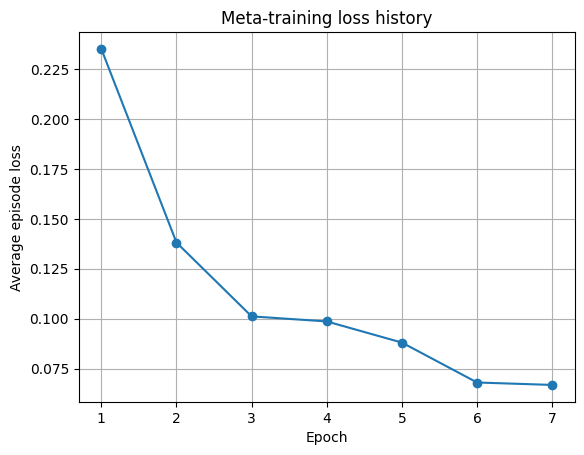

In [91]:
## Plot of meta learner performance

from pathlib import Path

loss_history = np.array(loss_history)
epochs = range(1, len(loss_history) + 1)

plt.figure()
plt.plot(epochs, loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average episode loss")
plt.title("Meta-training loss history")
plt.grid(True)
plt.show()

**Interpretation of the average episode loss**  
The “avg episode loss” at each epoch is the average cross-entropy error over all support–query tasks in that epoch; the fact that it steadily goes from ~0.24 to ~0.07 means that the encoder is successfully learning a feature space where prototype-based segmentation works increasingly well.

> **Recap what episodes are**  
> For one episode, you:
> - Take (support_image, support_mask, query_image, query_mask).
> - Encode support &rarr; compute prototypes (foreground/background).
> - Encode query &rarr; classify each pixel using the prototypes.
> - Compare predicted class vs true class at each pixel of the query.
> - Compute a cross-entropy loss over all those pixels.

### Few-shot inference: 1-shot and K-shot helpers

After meta-training, comes meta-learning. You want to use the encoder for **few-shot segmentation** on new data.

For that, you define a function where:  
- `k_shot_predict` takes:
  - `K` support images and masks, and
  - a query image,
  and returns the full-resolution logits `[1, 2, H, W]` for the query.
- Internally, it encodes supports and query, computes prototypes using all K supports, classifies the query at the feature resolution, and upsamples the logits back to the original image size.

For convenience, `one_shot_predict` wraps this function for the special case `K = 1`. These utilities are used both for quantitative evaluation and for visualising qualitative results.

In [92]:
def k_shot_predict(encoder, support_imgs, support_masks, query_img):
    """
    K-shot segmentation for a query image given K support images+masks.

    support_imgs:  [K, 3, H, W]
    support_masks: [K, 1, H, W]
    query_img:     [3, H, W]
    Returns: logits [1, 2, H, W]
    """
    encoder.eval()
    with torch.no_grad():
        support_imgs = support_imgs.to(device)
        support_masks = support_masks.to(device)
        query_img = query_img.to(device).unsqueeze(0)

        # Pass through encoder
        feat_s = encoder(support_imgs)
        feat_q = encoder(query_img)

        # Compute prototypes
        prototypes = compute_prototypes(feat_s, support_masks)

        # Classify query pixels
        logits_small = classify_query(feat_q, prototypes)
        logits = F.interpolate(
            logits_small,
            size=(query_img.shape[2], query_img.shape[3]),
            mode="bilinear",
            align_corners=False,
        )

    return logits.cpu()


def one_shot_predict(encoder, support_img, support_mask, query_img):
    """
    1-shot helper that wraps single support into K=1 form.
    """
    support_imgs = support_img.unsqueeze(0)
    support_masks = support_mask.unsqueeze(0)
    return k_shot_predict(encoder, support_imgs, support_masks, query_img)

<a name="results"></a>
##  Results

### Quantitative evaluation: K-shot IoU

To assess the model, you evaluate **K-shot IoU** on the test split:

- For each test image (query), you randomly sample `K` distinct support images from the training split.
- You run `k_shot_predict` to obtain predicted logits and compute IoU with respect to the true rooftop mask.
- You repeat this process for multiple random test queries and report the **mean and standard deviation of IoU**.

By varying `K` you can study how performance improves as you provide more labelled examples to the model.


In [93]:
def evaluate_kshot_iou(encoder, train_dataset, test_dataset, K=5, num_samples=None):
    """
    Evaluate K-shot IoU on 'num_samples' random test images.
    For each test image, randomly sample K distinct support images from the train set.
    """
    encoder.eval()
    rng = np.random.default_rng(42)

    # If num_samples is None, evaluate on all test samples
    if num_samples is None:
        num_samples = len(test_dataset)

    ious = []
    for _ in range(num_samples):
        ti = rng.integers(0, len(test_dataset))
        img_q, mask_q = test_dataset[ti]

        support_indices = rng.choice(len(train_dataset), size=K, replace=False)
        support_imgs = []
        support_masks = []
        for si in support_indices:
            img_s, mask_s = train_dataset[si]
            support_imgs.append(img_s)
            support_masks.append(mask_s)
        support_imgs = torch.stack(support_imgs, dim=0)
        support_masks = torch.stack(support_masks, dim=0)

        # run K-shot prediction
        logits = k_shot_predict(encoder, support_imgs, support_masks, img_q)  # [1,2,H,W]

        iou = iou_from_logits(logits, mask_q.unsqueeze(0))
        ious.append(iou)

    ious = np.array(ious)
    print(f"{K}-shot mean IoU over {num_samples} test samples: {ious.mean():.3f}")
    return ious

### Visualising a 1-shot prediction

In [98]:
def tensor_to_rgb(img_tensor):
    """Undo normalisation and convert [3,H,W] tensor to [H,W,3] RGB numpy."""
    img_np = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    return img_np


def visualise_few_shot_example(encoder, train_dataset, test_dataset):
    encoder.eval()
    rng = np.random.default_rng()

    # Pick support from train, query from test
    si = rng.integers(0, len(train_dataset))
    ti = rng.integers(0, len(test_dataset))

    img_s, mask_s = train_dataset[si]
    img_q, mask_q = test_dataset[ti]

    logits = one_shot_predict(encoder, img_s, mask_s, img_q)
    pred_mask = logits.argmax(dim=1, keepdim=True).float().squeeze(0).squeeze(0).numpy()

    # Convert to numpy for plotting
    img_s_np = tensor_to_rgb(img_s)
    img_q_np = tensor_to_rgb(img_q)
    mask_s_np = mask_s.squeeze(0).numpy()
    mask_q_np = mask_q.squeeze(0).numpy()

    plt.figure(figsize=(12, 6))

    # Row 1: Support
    plt.subplot(2, 3, 1)
    plt.imshow(img_s_np)
    plt.title("Support image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(mask_s_np, cmap="gray")
    plt.title("Support mask")
    plt.axis("off")

    # Row 2: Query
    plt.subplot(2, 3, 4)
    plt.imshow(img_q_np)
    plt.title("Query image")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(mask_q_np, cmap="gray")
    plt.title("Ground Truth (Query)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted (Query)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

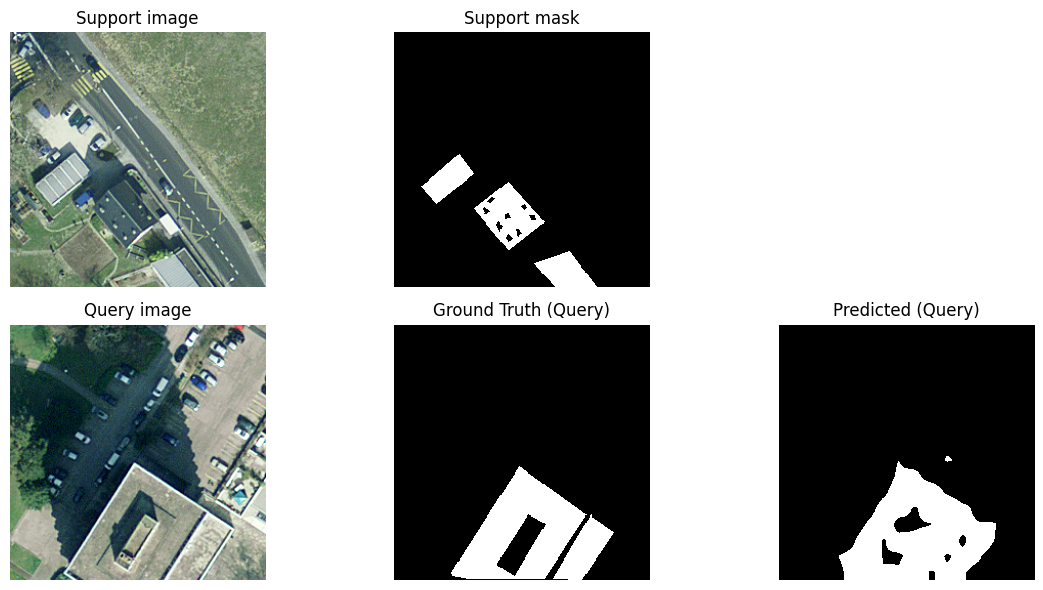

In [106]:
visualise_few_shot_example(encoder, train_base, test_base)

### Visualising a 5-shot prediction

Finally, you can visualise a **K-shot** episode (e.g. 5-shot) to complement the numerical results. For that:

1. Select a random query image from the test set.
2. Select `K` random support images from the training set.
3. Run `k_shot_predict` to produce a predicted mask.
4. Plot:
   - the query image,
   - the ground-truth query mask,
   - and the K-shot predicted mask.

Qualitatively comparing this to the 1-shot visualisation help you to see where additional support images improve the segmentation—typically in challenging cases such as partially occluded rooftops or unusual roof materials.


In [109]:
def visualise_kshot_example(encoder, train_dataset, test_dataset, K=5):
    encoder.eval()
    rng = np.random.default_rng()

    # pick query from test
    ti = rng.integers(0, len(test_dataset))
    img_q, mask_q = test_dataset[ti]

    # pick K supports from train
    support_indices = rng.choice(len(train_dataset), size=K, replace=False)
    support_imgs, support_masks = [], []
    for si in support_indices:
        img_s, mask_s = train_dataset[si]
        support_imgs.append(img_s)
        support_masks.append(mask_s)
    support_imgs = torch.stack(support_imgs, dim=0)  # [K,3,H,W]
    support_masks = torch.stack(support_masks, dim=0)  # [K,1,H,W]

    # prediction
    logits = k_shot_predict(encoder, support_imgs, support_masks, img_q)
    pred_mask = logits.argmax(dim=1, keepdim=True).float().squeeze().numpy()

    img_q_np = tensor_to_rgb(img_q)
    mask_q_np = mask_q.squeeze(0).numpy()

    # Plot
    cols = max(K, 3)
    plt.figure(figsize=(4 * cols, 8))

    # first row: support images
    for i in range(K):
        plt.subplot(2, cols, i + 1)
        plt.imshow(tensor_to_rgb(support_imgs[i]))
        plt.title(f"Support {i+1} image")
        plt.axis("off")

    # second row: support masks
    for i in range(K):
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(support_masks[i].squeeze(0).numpy(), cmap="gray")
        plt.title(f"Support {i+1} mask")
        plt.axis("off")

    # query image & masks to the right (replace last columns if needed)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_q_np)
    plt.title("Query image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_q_np, cmap="gray")
    plt.title("Ground Truth mask (Query)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title(f"Predicted mask ({K}-shot)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

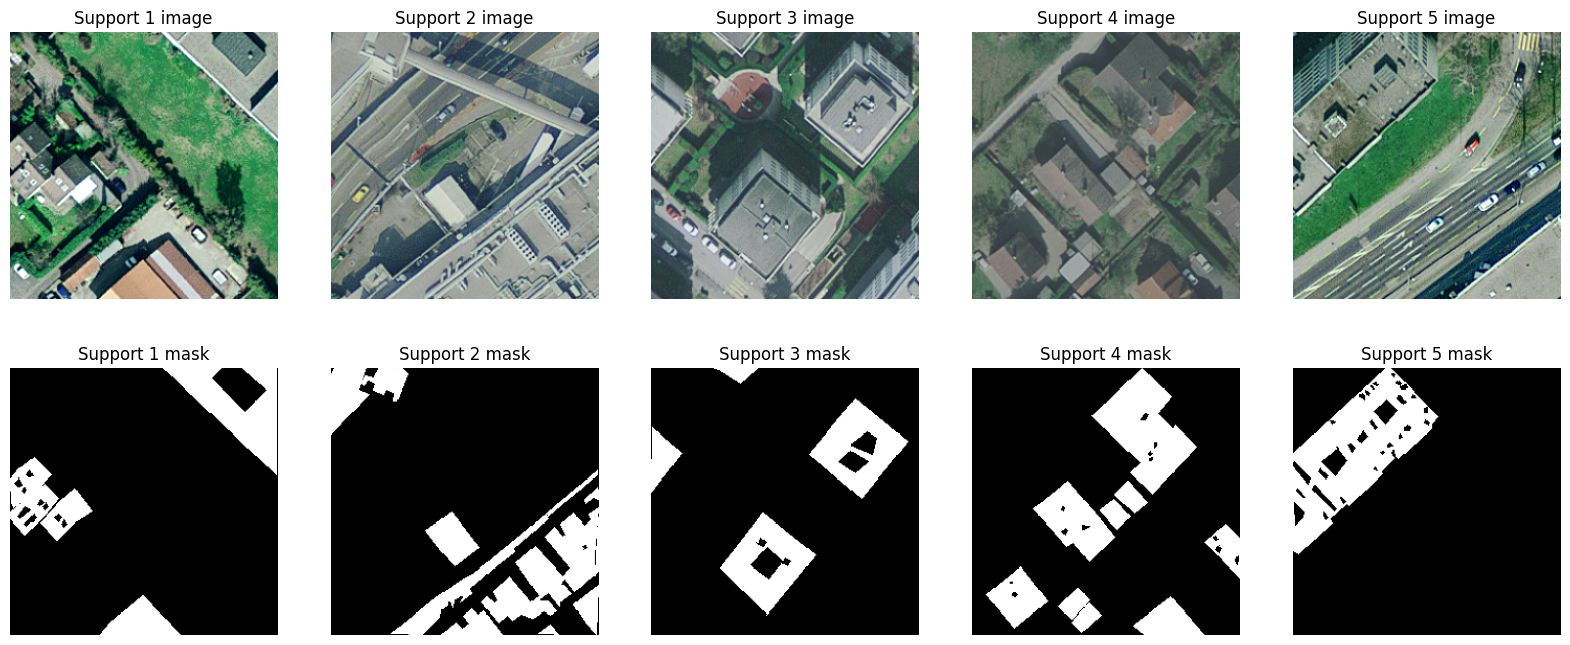

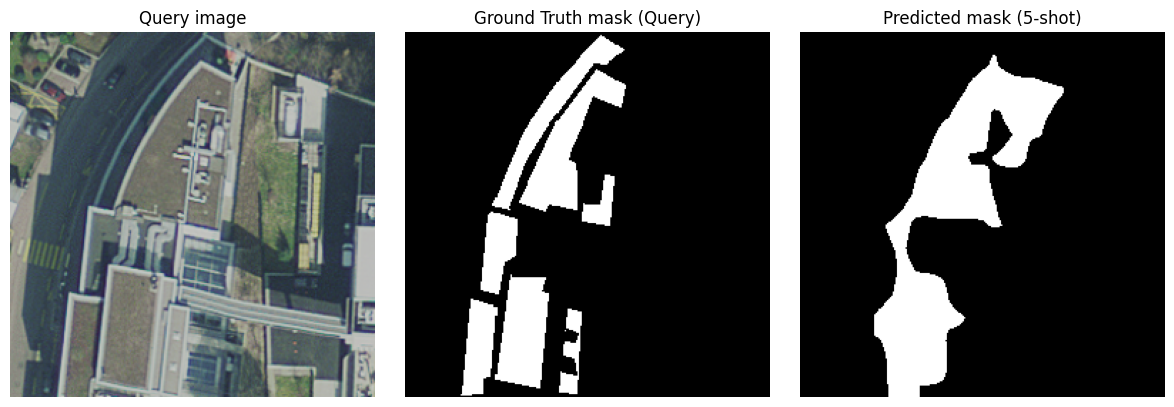

In [110]:
visualise_kshot_example(encoder, train_base, test_base, K=5)

### Comparing 1-shot and K-shot performance

Using the evaluation function above, you can now compare:

- **1-shot IoU**
- **5-shot IoU**
- **10-shot IoU**
- **20-shot IoU**

You would expect performance to improve with more support examples, as the prototypes become more representative of the diversity of rooftop appearances. This experiment illustrates a key trade-off in few-shot learning between **annotation cost** (how many labelled examples we need) and **model performance**.

In [111]:
ious_1shot = evaluate_kshot_iou(encoder, train_base, test_base, K=1, num_samples=None)
ious_5shot = evaluate_kshot_iou(encoder, train_base, test_base, K=5, num_samples=None)
ious_10shot = evaluate_kshot_iou(encoder, train_base, test_base, K=10, num_samples=None)
ious_20shot = evaluate_kshot_iou(encoder, train_base, test_base, K=20, num_samples=None)

1-shot mean IoU over 102 test samples: 0.473
5-shot mean IoU over 102 test samples: 0.491
10-shot mean IoU over 102 test samples: 0.482
20-shot mean IoU over 102 test samples: 0.482


To summarise, in this tutorial, you monitored two key indicators: the meta-training loss and the IoU of the predicted masks.

#### **1. Meta-Training Loss**

Across epochs, this loss **decreases steadily**, indicating that:

- the encoder learns a progressively more meaningful **feature representation**  
- rooftop vs. non-rooftop pixels become **more separable** in feature space  
- prototype-based segmentation improves throughout meta-training  

Even with very limited supervision, the model internalizes **rooftop characteristics** and reduces prediction errors effectively.

#### **2. Predicted Masks & Quantitative Performance**

To evaluate the model, we report **few-shot segmentation** results across different numbers of labeled support examples:

- **1-shot:** 1 labeled support example per test episode  
- **5-shot:** 5 labeled support examples per test episode  
- **10-shot:** 10 labeled support examples per test episode  
- **20-shot:** 20 labeled support examples per test episode  

On a set of **102 test tiles** drawn from a geographically distinct region of Geneva, the model achieves:

➡️ **1-shot mean IoU:** ~0.47  
➡️ **5-shot mean IoU:** ~0.49  
➡️ **10-shot mean IoU:** ~0.48  
➡️ **20-shot mean IoU:** ~0.48  

While modest, these results are encouraging given:  

- the strong label constraints  
- the complexity of urban rooftop structures  
- the geographic domain shift between training and testing


A qualitative example highlights this behavior:

- Support images & masks define the relevant rooftop characteristics  
- On the query image, the predicted mask captures **major rooftop shapes**  
- Large rooftop surfaces are generally identified  
- Fine-grained details remain imperfect, but the model generalizes to **textures and geometries not seen during training**

These results suggest that the Prototypical Network successfully learns a **useful and transferable feature embedding**.  

---

<a name="discussion-limitations"></a>

## **Discussion**

The results show that Prototypical Networks can learn meaningful rooftop representations even with very limited supervision. However, there remains substantial room to improve performance and explore alternative design choices within the few-shot learning setup. Several aspects of the training procedure could be refined to enhance segmentation accuracy:

#### **Model Tuning and Regularization**

Incorporating techniques such as **weight decay**, **dropout** or **early stopping** could stabilize feature learning and reduce overfitting to the small support sets typically used in few-shot learning.

#### **Training for More Epochs**

For demonstration purposes, the model was trained for only a limited number of epochs. Extending training duration or increasing the number of sampled episodes per epoch could help the encoder converge toward a **more discriminative embedding space**, potentially improving segmentation performance.

#### **Extending the Task Toward Policy Relevance**

A rough solar potential approximation could be built on top of the segmentation task. For example by combining the predicted rooftop area with IoU-based uncertainty estimates. This could provide a **first-order indicator of solar suitability**, connecting the model’s outputs to real-world energy planning applications.

#### **Trying Different Encoder Backbones**

The current prototype uses a lightweight CNN encoder for simplicity. Replacing it with stronger architectures such as **ResNet-50** or a **Vision Transformer (ViT)** may yield more robust and generalizable feature representations.

---


## Limitations

While this tutorial successfully demonstrates the core ideas behind few-shot segmentation with **Prototypical Networks**, several important simplifications limit its applicability. Many of these choices were made intentionally to ensure the tutorial remains computationally lightweight and easy to reproduce.

#### **Simplified Experimental Setup**

To keep the workflow accessible, we used:

- a **very small training set**, both in the number of tiles and support examples per episode  
- a **lightweight encoder**, rather than higher-capacity backbones common in remote sensing (e.g., ResNet-50, Swin Transformer)  
- a **short training schedule**, with few epochs and limited episode sampling  

These design choices improve reproducibility but also **restrict the achievable segmentation performance**.  
In practical applications—such as large-scale rooftop or solar mapping—substantially **more data**, **stronger feature extractors**, and **longer training** would be necessary.

#### **Modelling Choices Intentionally Kept Simple**

Several simplifications reduce the robustness of the resulting predictions:

- **Binary segmentation** (roof vs. non-roof) ignores roof type, material, shadows, and occlusions—all of which matter for accurate solar potential estimation.  
- **No post-processing** was applied (e.g., morphological filters, CRFs), even though such steps typically improve mask quality.  
- **No uncertainty estimation** was included, despite being crucial for planning and policy-relevant applications.

These omissions help focus on core concepts but limit real-world applicability.

#### **Dataset Biases and Generalization Limits**

The dataset itself introduces structural biases:

- Imagery is taken exclusively from **Geneva**, a wealthy European city with relatively homogeneous architectural styles.  
- Rooftop morphology varies globally—informal housing, climate-adapted roof shapes, and diverse materials are **not represented** here.  
- The geographic split (North–Center–South) creates a **stylized domain shift**, but does not reflect true global variation.

If applied uncritically in policy contexts, these limitations could **reinforce geographic inequities**—for example, overestimating solar potential in well-represented neighborhoods and underestimating it in underrepresented ones.

#### **Addressing These Challenges**

To improve real-world deployment, data analysts and practitioners should consider:

- **Expanding dataset diversity** (more cities, varied roof types, lighting conditions, seasons).  
- **Evaluating fairness and generalization** across socioeconomic and geographic groups.  
- **Incorporating uncertainty estimation**, especially when predictions support infrastructure or planning decisions.  
- **Validating model outputs** with domain experts (urban planners, energy modelers, local authorities).

By recognizing these limitations, we can better understand the conditions under which few-shot rooftop segmentation performs well—and the steps required to make such models reliable for operational or policy-driven use.


---

<a name="challenge"></a>
## ⭐ Challenge ⭐

### **Photovoltaic Capacity Estimation in France via Prototypical Network Segmentation**


### **Overview**

In this challenge, you can check your new knowledge and apply your new skills to estimate PV capacities in France. For that you will use a dataset containing RGB aerial imagery of buildings and landscapes, polygon segmentation masks of photovoltaic (PV) arrays and installation metadata (location and nominal capacity) for thousands of solar installations across France. The dataset can be accessed [here](https://zenodo.org/records/7358126).

Your objectives are to:

1. **Segment PV arrays** in unseen aerial RGB images using the provided segmentation masks  
   (i.e., generate per-pixel segmentation masks of solar panels).

2. **Compare segmentation results** with installation metadata (`metadata.csv`), which includes ground-truth installation characteristics.

3. **Evaluate**:
   - **(a)** your practical application of Prototypical Network–based segmentation,  
   - **(b)** the model’s ability to generalize to a new dataset,  
   - **(c)** the accuracy of area-based PV capacity estimates when compared against reported capacities.

You can use following ressources to help you:

- **Published Paper**:

  [Nature Article](https://www.nature.com/articles/s41597-023-01951-4)

- **GitHub Repository (tools & implementation guidance)**:
  
  [BDAP-PV Repository](https://github.com/gabrielkasmi/bdappv)


---

<a name="further-ressources"></a>
## Further Ressources

### **Foundational Papers**

- **Shaban, A., Bansal, S., Liu, Z., Essa, I., & Boots, B. (2017).** One-Shot Learning for Semantic Segmentation. *BMVC.*  
  [https://doi.org/10.48550/arXiv.1709.03410](https://doi.org/10.48550/arXiv.1709.03410)  
  → First paper to formally define the few-shot semantic segmentation task.  
  → Introduces a conditioning branch that generates segmentation parameters from support examples.

- **Snell, J., Swersky, K., & Zemel, R. (2017).** Prototypical Networks for Few-Shot Learning. *Advances in Neural Information Processing Systems (NeurIPS 2017), Vol. 30.*  
  [https://doi.org/10.48550/arXiv.1703.05175](https://doi.org/10.48550/arXiv.1703.05175)  
  → Establishes the concept of class prototypes derived from support embeddings.  
  → Influences nearly all metric-based few-shot segmentation methods.

- **Wang, K., Liew, J. H., Zou, Y., Zhou, D., & Feng, J. (2019).** PANet: Few-Shot Image Semantic Segmentation with Prototype Alignment. *ICCV.*  
  [https://doi.org/10.48550/arXiv.1908.06391](https://doi.org/10.48550/arXiv.1908.06391)  
  → Introduces prototype alignment networks to better utilize support-set information.  
  → Serves as a strong and efficient baseline for few-shot segmentation.

- **Tian, Z., Zhao, H., Shu, M., Yang, Z., Li, R., & Jia, J. (2020).** Prior Guided Feature Enrichment Network for Few-Shot Segmentation. *IEEE TPAMI, 44*(2), 1050–1065.  
  [https://doi.org/10.1109/TPAMI.2020.3013717](https://doi.org/10.1109/TPAMI.2020.3013717)  
  → Introduces PFENet, significantly improving generalization.  
  → Set a new benchmark after PANet for high-performance few-shot segmentation.

### **Other Ressources**

- **Code of the original implementation of Prototypical Networks (Snell et al., 2017)**  
  https://github.com/jakesnell/prototypical-networks

- **Video explanation of Prototypical Networks (deep dive into concepts + code)**  
  https://www.youtube.com/watch?v=rHGPfl0pvLY

- **Comprehensive GitHub repository on many few-shot learning techniques**  
  https://github.com/sicara/easy-few-shot-learning?tab=readme-ov-file

- **Transformer-based state-of-the-art segmentation: YOLOE (Zero-shot detection & segmentation)**  
  https://github.com/THU-MIG/yoloe

- **Transformer-based state-of-the-art segmentation: SAM Models (Segment Anything Model — Meta AI)**  
  https://github.com/facebookresearch/segment-anything


---

<a name="references"></a>
## References

- Alsentzer, E., Li, M. M., Kobren, S. N., Noori, A., Undiagnosed Diseases Network, Kohane, I. S., & Zitnik, M. (2025). Few shot learning for phenotype-driven diagnosis of patients with rare genetic diseases. *npj Digital Medicine, 8*(1), 380. [https://doi.org/10.1038/s41746-025-01749-1](https://doi.org/10.1038/s41746-025-01749-1)

- Castello, R., Walch, A., Attias, R., Cadei, R., Jiang, S., & Scartezzini, J.-L. (2021). Quantification of the suitable rooftop area for solar panel installation from overhead imagery using convolutional neural networks. *Journal of Physics: Conference Series, 2042*(1), 012002. [https://doi.org/10.1088/1742-6596/2042/1/012002](https://doi.org/10.1088/1742-6596/2042/1/012002)

- Chen, Y., Wei, C., Wang, D., Ji, C., & Li, B. (2022). Semi-supervised contrastive learning for few-shot segmentation of remote sensing images. *Remote Sensing, 14*(17), 4254. [https://doi.org/10.3390/rs14174254](https://doi.org/10.3390/rs14174254)

- Ding, H., Zhang, H., & Jiang, X. (2022). Self-regularized prototypical network for few-shot semantic segmentation. *Pattern Recognition, 132*, 109018. [https://doi.org/10.1016/j.patcog.2022.109018](https://doi.org/10.1016/j.patcog.2022.109018)

- Finn, C., Abbeel, P., & Levine, S. (2017). Model-agnostic meta-learning for fast adaptation of deep networks. In *International Conference on Machine Learning* (pp. 1126–1135). PMLR. [https://doi.org/10.48550/arXiv.1703.03400](https://doi.org/10.48550/arXiv.1703.03400)

- Ge, Z., Fan, X., Zhang, J., & Jin, S. (2025). SegPPD-FS: Segmenting plant pests and diseases in the wild using few-shot learning. *Plant Phenomics*, 100121. [https://doi.org/10.1016/j.plaphe.2025.100121](https://doi.org/10.1016/j.plaphe.2025.100121)

- Hu, Y., Liu, C., Li, Z., Xu, J., Han, Z., & Guo, J. (2022). Few-shot building footprint shape classification with relation network. *ISPRS International Journal of Geo-Information, 11*(5), 311. [https://doi.org/10.3390/ijgi11050311](https://doi.org/10.3390/ijgi11050311)

- Jadon, S. (2021, February). COVID-19 detection from scarce chest x-ray image data using few-shot deep learning approach. In *Medical Imaging 2021: Imaging Informatics for Healthcare, Research, and Applications* (Vol. 11601, pp. 161–170). SPIE. [https://doi.org/10.1117/12.2581496](https://doi.org/10.1117/12.2581496)

- Lee, G. Y., Dam, T., Ferdaus, M. M., Poenar, D. P., & Duong, V. (2025). Enhancing Few-Shot Classification of Benchmark and Disaster Imagery with ATTBHFA-Net. *arXiv preprint arXiv:2510.18326.* [https://doi.org/10.48550/arXiv.2510.18326](https://doi.org/10.48550/arXiv.2510.18326)

- Li, X., He, Z., Zhang, L., Guo, S., Hu, B., & Guo, K. (2025). CDCNet: Cross-domain few-shot learning with adaptive representation enhancement. *Pattern Recognition, 162*, 111382. [https://doi.org/10.1016/j.patcog.2025.111382](https://doi.org/10.1016/j.patcog.2025.111382)

- Puthumanaillam, G., & Verma, U. (2023). Texture based prototypical network for few-shot semantic segmentation of forest cover: Generalizing for different geographical regions. *Neurocomputing, 538*, 126201. [https://doi.org/10.1016/j.neucom.2023.03.062](https://doi.org/10.1016/j.neucom.2023.03.062)

- Sung, F., Yang, Y., Zhang, L., Xiang, T., Torr, P. H., & Hospedales, T. M. (2018). Learning to compare: Relation network for few-shot learning. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition* (pp. 1199–1208). [https://doi.org/10.1109/CVPR.2018.00131](https://doi.org/10.1109/CVPR.2018.00131)
